# Metadata

**Author**: Ejay Aguirre

**Last Updated**: 08-07-2025

**Location Source(s)**: 
* DP1.00002.001
* DP1.20053.001 

**Link**: https://data.neonscience.org/data-products/explore

**Citation**: NEON (National Ecological Observatory Network). Single aspirated air temperature (DP1.00002.001), RELEASE-2025. https://doi.org/10.48443/hejx-aa82. Dataset accessed from https://data.neonscience.org/data-products/DP1.00002.001/RELEASE-2025 on August 2, 2025.\
NEON (National Ecological Observatory Network). Temperature (PRT) in surface water (DP1.20053.001), RELEASE-2025. https://doi.org/10.48443/0cm0-gh54. Dataset accessed from https://data.neonscience.org/data-products/DP1.20053.001/RELEASE-2025 on August 4, 2025.

# Introduction

This notebook retrieves and processes air and water temperature data from the National Ecological Observatory Network (NEON) Data API.\
The analysis focuses on comparing resampled air temperature from three specific NEON sites (ABBY, TEAK, and PUUM) with the Ocean Niño Index (ONI) to explore potential trends and correlations between local conditions and the large-scale climate phenomena. It will also focus on resampled water temperature from three specific NEON sites (MCRA, BIGC, MCDI).\
The data is visualized with ENSO event overlays to provide a clear temporal context for temperature fluctuations.

### Required Libraries

This notebook requires the following Python Libraries:
* `requests`
* `pandas`
* `matplotlib`

You can install them using the following command:
```bash
!pip install requests pandas matplotlib 

In [184]:
!pip install requests pandas matplotlib -q

In [185]:
import json
import requests
import pandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [213]:
# OVERLAY DATA (see more from ENSO_Overlays.ipynb)
path = '/home/jovyan/oni.ascii.txt'
oni = pd.read_csv(
    path,
    delim_whitespace = True,
    skiprows = 1,     
    names = ['SEAS','YEAR','TOTAL','ANOMALY']
)

# Convert the 3-letter season code into a “mid-month” integer
season_to_month = {
    'DJF': 1, 'JFM': 2, 'FMA': 3, 'MAM': 4,
    'AMJ': 5, 'MJJ': 6, 'JJA': 7, 'JAS': 8,
    'ASO': 9, 'SON':10, 'OND':11, 'NDJ':12
}
oni['MONTH'] = oni['SEAS'].map(season_to_month)

# Build a datetime index at the 15th of the mid-month
oni['DATE'] = pd.to_datetime(dict(
    year = oni.YEAR,
    month = oni.MONTH,
    day = 15
))
oni = oni.set_index('DATE')

oni = oni.loc['2013-01-01':]

# Remove timezone information from the dataframe's index to ensure consistency
if getattr(df.index, "tz", None) is not None:
    df.index = df.index.tz_localize(None)
     
# Classify El Niño / La Niña / Neutral
def enso(x):
    if x >=  0.5: return 'El Niño'
    if x <= -0.5: return 'La Niña'
    return 'Neutral'

oni['PHASE'] = oni.ANOMALY.map(enso)

segments = []
grp = (oni.PHASE != oni.PHASE.shift()).cumsum()
for _, g in oni.groupby(grp):
    start = g.index.min()
    end = g.index.max() + pd.Timedelta(days = 14)
    # FORCE tz‐naive on segment endpoints
    if getattr(start, "tz", None) is not None:
        start = start.tz_localize(None)
    if getattr(end,   "tz", None) is not None:
        end = end.tz_localize(None)
    segments.append((start, end, g.PHASE.iloc[0]))

/tmp/ipykernel_13756/1446395711.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  oni = pd.read_csv(


# NEON Air Temperature

The following few code blocks interacts with NEON's Data API to download data (DP1.00002.001) from specific sites.
The sites "ABBY", "TEAK", and "PUUM" were chosen to their geographic locations, which may show trends related to OOI and ENSO data.

In [210]:
def fetch_airtemp(sites, resolution = "30min", product_id = product_id, output_dir = "/home/jovyan/NEON_Temperature/data"):
    """
    Fetches data from the NEON API for a list of specificed sites.

    This function iterates through a list of NEON site codes, find the avialable data
    for a given product ID and resolution, downloades the relevant CSV files,
    and process the data to a consistent format.

    Parameters:
    - sites (list): A list of NEON site codes
    - resolution (str): The time resolution of the data product ID
    - product_id (str): The NEON data product identifier
    - output_dir (str): The local directory to save the processed CSV file
    
    Returns:
    A CSV file from each site
    """
    resp = requests.get(f"{base_url}/products/{product_id}")
    resp.raise_for_status()
    product = resp.json()["data"]
    
    for site in sites:
        
        print(f"\nProcessing site: {site}")
        entry = next((e for e in product["siteCodes"] if e["siteCode"] == site), None)
        if not entry:
            print(f"{site} not listed for {product_id}")
            continue

        months = entry.get("availableMonths", [])
        urls = entry.get("availableDataUrls", [])
        print(f"Found {len(months)} months of data")

        dfs = []

        for month, data_url in zip(months, urls):

            r = requests.get(data_url)
            if r.status_code != 200:
                print(f"Failed to list files for{site}-{month}")
                continue
            files = r.json()["data"]["files"]

            csv_url = None
            for f in files:
                name = f["name"].lower()
                if "aat" in name and resolution.lower() in name and name.endswith(".csv"):
                    csv_url = f["url"]
                    break

            if not csv_url:
                print(f"No CSV for {site}-{month}")
                continue
            print(f"Downloading {name}")
            
            try:
                df = pd.read_csv(csv_url)
            except Exception as e:
                print(f"Couldn’t read CSV: {e}")
                continue

            # only keep tempSingleMean
            cols = {c.lower():c for c in df.columns}
            if "tempsinglemean" not in cols:
                print("No tempSingleMean column, skipping")
                continue

            df = df[["startDateTime", cols["tempsinglemean"]]].dropna()
            df = df.rename(columns={
                "startDateTime": "Datetime",
                cols["tempsinglemean"]: "Temp_C"
            })
            df["Datetime"] = pd.to_datetime(df["Datetime"])
            df["Temp_F"] = df["Temp_C"] * 9/5 + 32
            df["Month"] = month
            dfs.append(df)

        if dfs:
            out = pd.concat(dfs, ignore_index = True)
            fn = os.path.join(output_dir, f"{site}_airtemp_{resolution}.csv")
            out.to_csv(fn, index = False)
            print(f"Saved: {fn}")
        else:
            print(f"No matching AAT_{resolution} files found for {site}")

In [197]:
# NEON base API URL
base_url = "https://data.neonscience.org/api/v0"

# Product ID for 30-minute air temperature
product_id = "DP1.00002.001"

# Sites that are related to Global Station Papa in terms of the EL Niño and La Niña
sites = ["ABBY", "TEAK", "PUUM"]

fetch_airtemp(sites)


Processing site: ABBY
Found 112 months of data
Saved: /home/jovyan/NEON_Temperature/data/ABBY_airtemp_30min.csv

Processing site: TEAK
Found 86 months of data
Saved: /home/jovyan/NEON_Temperature/data/TEAK_airtemp_30min.csv

Processing site: PUUM
Found 75 months of data
Saved: /home/jovyan/NEON_Temperature/data/PUUM_airtemp_30min.csv


In [191]:
# Initailize dataset paths
# Ensure to change to relative paths.
file_paths = [
    "/home/jovyan/NEON_Temperature/data/ABBY_airtemp_30min.csv",
    "/home/jovyan/NEON_Temperature/data/TEAK_airtemp_30min.csv",
    "/home/jovyan/NEON_Temperature/data/PUUM_airtemp_30min.csv"
]


# Load and compute daily means
daily_dfs = {}
for path in file_paths:
    site = os.path.basename(path).split("_")[0]
    df = pd.read_csv(path, parse_dates=["Datetime"])
    df.set_index("Datetime", inplace=True)

    if getattr(df.index, "tz", None) is not None:
        df.index = df.index.tz_localize(None)

    daily = df["Temp_F"].resample("M").mean().to_frame(name=site)
    daily_dfs[site] = daily

# Site metadata
metadata = {
    "ABBY": {"Location": "Abby Road, OR"},
    "TEAK": {"Location": "Teakettle Creek, CA"},
    "PUUM": {"Location": "Puu Makaala Natural Area Reserve, HI"}
}

/tmp/ipykernel_13756/2158279269.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily = df["Temp_F"].resample("M").mean().to_frame(name=site)
/tmp/ipykernel_13756/2158279269.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily = df["Temp_F"].resample("M").mean().to_frame(name=site)
/tmp/ipykernel_13756/2158279269.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily = df["Temp_F"].resample("M").mean().to_frame(name=site)


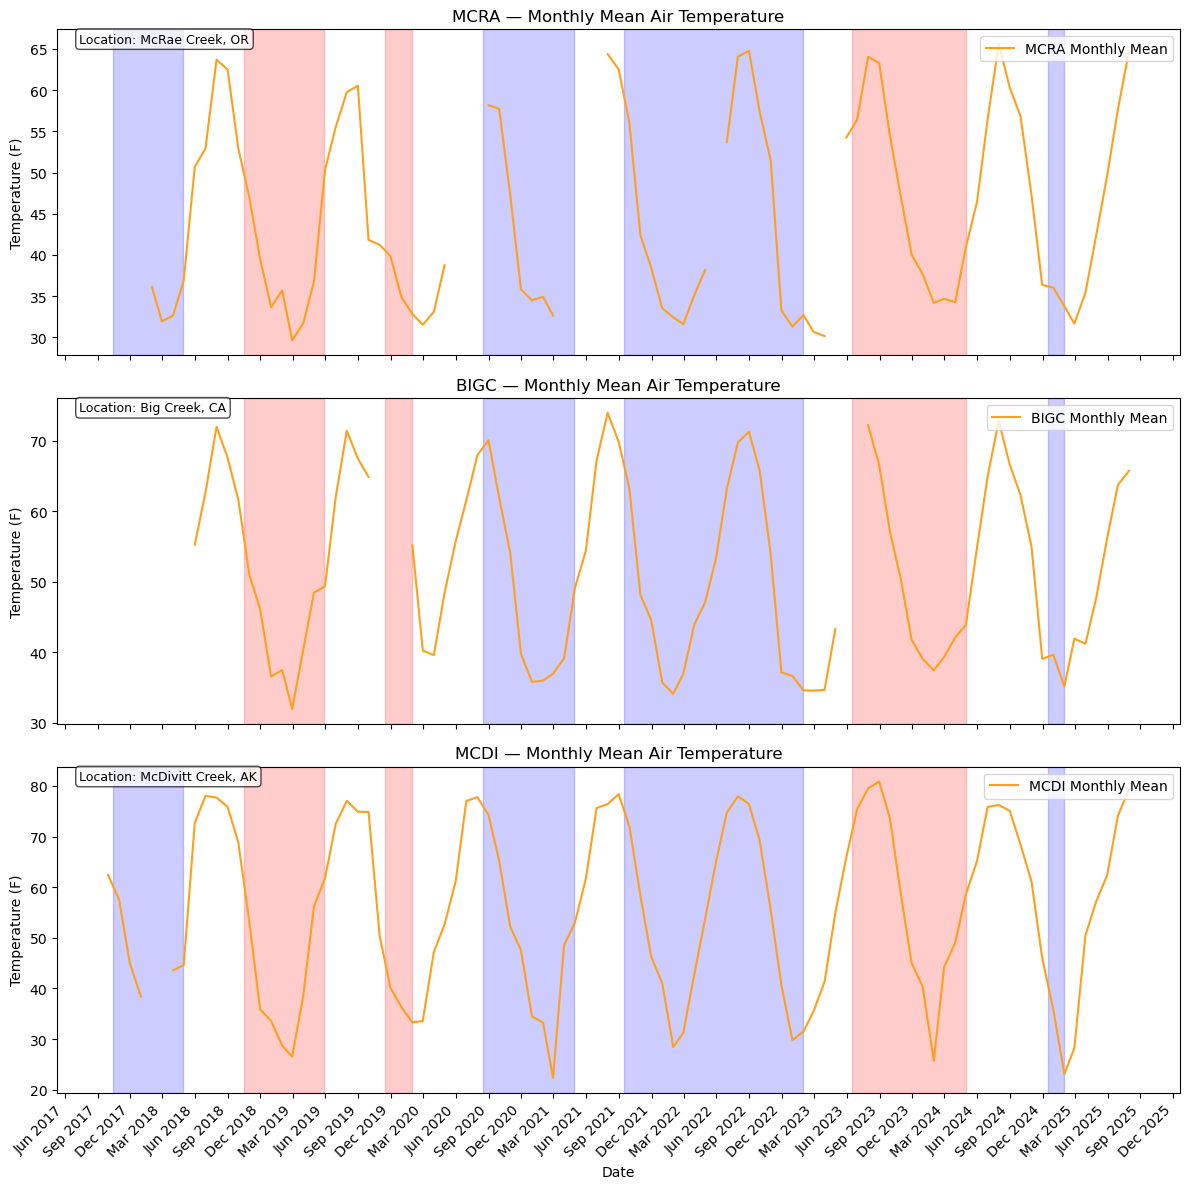

In [211]:
# Create subplots per site
n_sites = len(daily_dfs)

# Intializes plots
fig, axes = plt.subplots(n_sites, 1, figsize = (12, 4 * n_sites), sharex = True)
if n_sites == 1:
    axes = [axes]

for ax, (site, daily) in zip(axes, daily_dfs.items()):
    
    
    ax.plot(daily.index, daily[site], label=f"{site} Monthly Mean", color="#FF9F1C")
    ax.set_title(f"{site} — Monthly Mean Air Temperature")
    ax.set_ylabel("Temperature (F)")
    ax.legend(loc="upper right")

    # Overlay ENSO segments
    for start, end, phase in segments:
        if end < daily.index.min() or start > daily.index.max():
            continue
        color = 'red' if phase == 'El Niño' else ('blue' if phase == 'La Niña' else None)
        if color:
            ax.axvspan(start, end, color = color, alpha = 0.2, zorder = 0)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

    # Annotate metadata inside the plot
    meta = metadata.get(site, {})
    meta_text = "\n".join(f"{k}: {v}" for k, v in meta.items())
    ax.text(
        0.02, 0.95, meta_text,
        transform = ax.transAxes,
        va = "bottom", ha = "left",
        fontsize = 9,
        bbox = dict(boxstyle = "round,pad=0.3", facecolor = "white", alpha = 0.7)
    )

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.savefig("/home/jovyan/NEON_Temperature/images/monthly_air__temp_NEON.png", dpi = 300)
plt.show()

# NEON Water Temperature

The following few code blocks interacts with NEON's Data API to download data (DP1.20053.001) from specific sites.
The sites "MCRA", "BIGC", and "MCDI" were chosen to their geographic locations, which may show trends related to OOI and ENSO data.

In [212]:
def fetch_watertemp(sites, resolution = "30min", product_id = product_id, output_dir = "/home/jovyan/NEON_Temperature/data"):
    """
    Fetches data from the NEON API for a list of specificed sites.

    This function iterates through a list of NEON site codes, find the avialable data
    for a given product ID and resolution, downloades the relevant CSV files,
    and process the data to a consistent format.

    Parameters:
    - sites (list): A list of NEON site codes
    - resolution (str): The time resolution of the data product ID
    - product_id (str): The NEON data product identifier
    - output_dir (str): The local directory to save the processed CSV file
    
    Returns:
    A CSV file from each site
    """

    resp = requests.get(f"{base_url}/products/{product_id}")
    resp.raise_for_status()
    product = resp.json()["data"]
    
    for site in sites:
        
        print(f"\nProcessing site: {site}")
        entry = next((e for e in product["siteCodes"] if e["siteCode"] == site), None)
        if not entry:
            print(f"{site} not listed for {product_id}")
            continue

        months = entry.get("availableMonths", [])
        urls = entry.get("availableDataUrls", [])
        print(f"Found {len(months)} months of data")

        dfs = []

        for month, data_url in zip(months, urls):

            r = requests.get(data_url)
            if r.status_code != 200:
                print(f"Failed to list files for{site}-{month}")
                continue
            files = r.json()["data"]["files"]

            csv_url = None
            for f in files:
                name = f["name"].lower()
                if "aat" in name and resolution.lower() in name and name.endswith(".csv"):
                    csv_url = f["url"]
                    break

            if not csv_url:
                print(f"No CSV for {site}-{month}")
                continue
            print(f"Downloading {name}")
            
            try:
                df = pd.read_csv(csv_url)
            except Exception as e:
                print(f"Couldn’t read CSV: {e}")
                continue

            # only keep tempSingleMean
            cols = {c.lower():c for c in df.columns}
            if "tempsinglemean" not in cols:
                print("No tempSingleMean column, skipping")
                continue

            df = df[["startDateTime", cols["tempsinglemean"]]].dropna()
            df = df.rename(columns={
                "startDateTime": "Datetime",
                cols["tempsinglemean"]: "Temp_C"
            })
            df["Datetime"] = pd.to_datetime(df["Datetime"])
            df["Temp_F"] = df["Temp_C"] * 9/5 + 32
            df["Month"] = month
            dfs.append(df)

        if dfs:
            out = pd.concat(dfs, ignore_index=True)
            fn = os.path.join(output_dir, f"{site}_watertemp_{resolution}.csv")
            out.to_csv(fn, index=False)
            print(f"Saved: {fn}")
        else:
            print(f"No matching AAT_{resolution} files found for {site}")

In [203]:
# NEON base API URL
base_url = "https://data.neonscience.org/api/v0"

# Product ID for 30-minute water temperature
product_id = "DP1.20053.001"

# Sites that are related to Global Station Papa in terms of the EL Nino and La Nina
sites = ["MCRA", "BIGC", "MCDI"]

fetch_watertemp(sites)


Processing site: MCRA
Found 91 months of data
Saved: /home/jovyan/NEON_Temperature/data/MCRA_watertemp_30min.csv

Processing site: BIGC
Found 87 months of data
Saved: /home/jovyan/NEON_Temperature/data/BIGC_watertemp_30min.csv

Processing site: MCDI
Found 95 months of data
Saved: /home/jovyan/NEON_Temperature/data/MCDI_watertemp_30min.csv


In [206]:
# Initailize dataset paths
file_paths = [
    "/home/jovyan/NEON_Temperature/data/MCRA_watertemp_30min.csv",
    "/home/jovyan/NEON_Temperature/data/BIGC_watertemp_30min.csv",
    "/home/jovyan/NEON_Temperature/data/MCDI_watertemp_30min.csv"
]


# Load and compute daily means
daily_dfs = {}
for path in file_paths:
    site = os.path.basename(path).split("_")[0]
    df = pd.read_csv(path, parse_dates = ["Datetime"])
    df.set_index("Datetime", inplace = True)

    if getattr(df.index, "tz", None) is not None:
        df.index = df.index.tz_localize(None)

    monthly = df["Temp_F"].resample("M").mean().to_frame(name=site)
    daily_dfs[site] = monthly

# Site metadata
metadata = {
    "MCRA": {"Location": "McRae Creek, OR"},
    "BIGC": {"Location": "Big Creek, CA"},
    "MCDI": {"Location": "McDivitt Creek, AK"}
}

/tmp/ipykernel_13756/4207236194.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df["Temp_F"].resample("M").mean().to_frame(name=site)
/tmp/ipykernel_13756/4207236194.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df["Temp_F"].resample("M").mean().to_frame(name=site)
/tmp/ipykernel_13756/4207236194.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df["Temp_F"].resample("M").mean().to_frame(name=site)


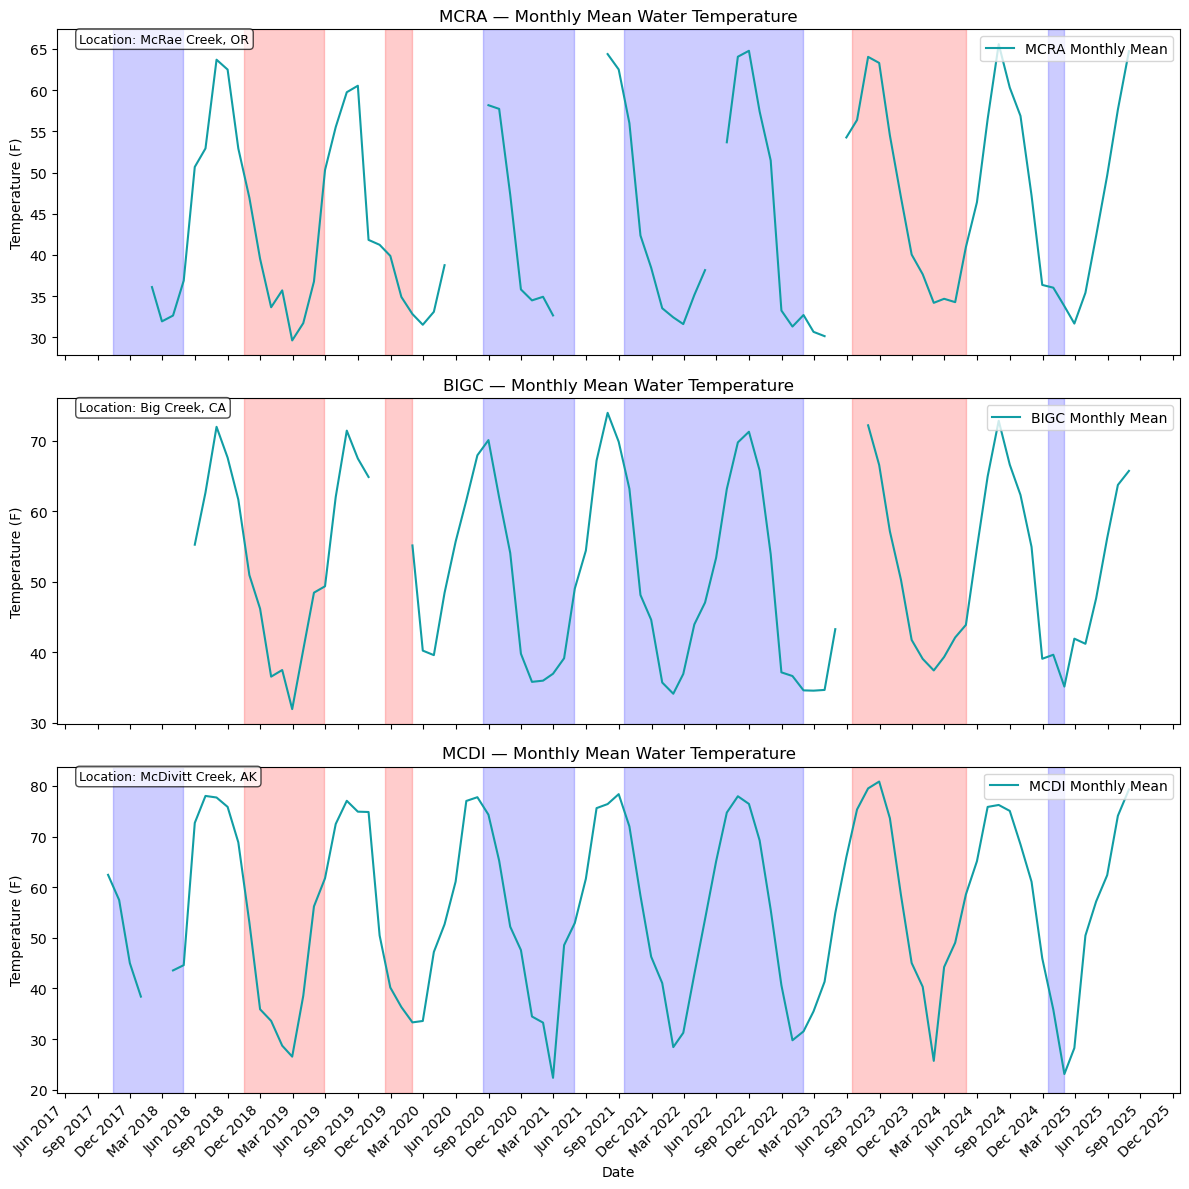

In [205]:
# Create subplots per site
n_sites = len(daily_dfs)

# Intializes plots
fig, axes = plt.subplots(n_sites, 1, figsize=(12, 4 * n_sites), sharex=True)
if n_sites == 1:
    axes = [axes]

for ax, (site, daily) in zip(axes, daily_dfs.items()):
    
    
    ax.plot(daily.index, daily[site], label=f"{site} Monthly Mean", color="#119DA4")
    ax.set_title(f"{site} — Monthly Mean Water Temperature")
    ax.set_ylabel("Temperature (F)")
    ax.legend(loc="upper right")

    # Overlay ENSO segments
    for start, end, phase in segments:
        if end < daily.index.min() or start > daily.index.max():
            continue
        color = 'red' if phase=='El Niño' else ('blue' if phase=='La Niña' else None)
        if color:
            ax.axvspan(start, end, color=color, alpha=0.2, zorder=0)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

    # Annotate metadata inside the plot
    meta = metadata.get(site, {})
    meta_text = "\n".join(f"{k}: {v}" for k, v in meta.items())
    ax.text(
        0.02, 0.95, meta_text,
        transform=ax.transAxes,
        va="bottom", ha="left",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

# 6) Final tweaks
axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.savefig("/home/jovyan/NEON_Temperature/images/daily_water__temp_NEON.png", dpi=300)
plt.show()

### Analysis

The visualizations in this notebook provide a cear overview of the air temperature trends at the selected NEON sites and thier relationship with ENSO events.
There were no singnifcance form the data that suggest any correlations with the ENSO data. It seems to only show seasonal data.